# Data Wrangling & Standardization

In [1]:
#load in necessary packages
import pandas as pd
import numpy as np
pd.options.display.max_columns = 100
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns
import datetime, tqdm

import math

from scipy.spatial import Voronoi, voronoi_plot_2d

### Football Field!

(<Figure size 1728x911.52 with 1 Axes>, <AxesSubplot:>)

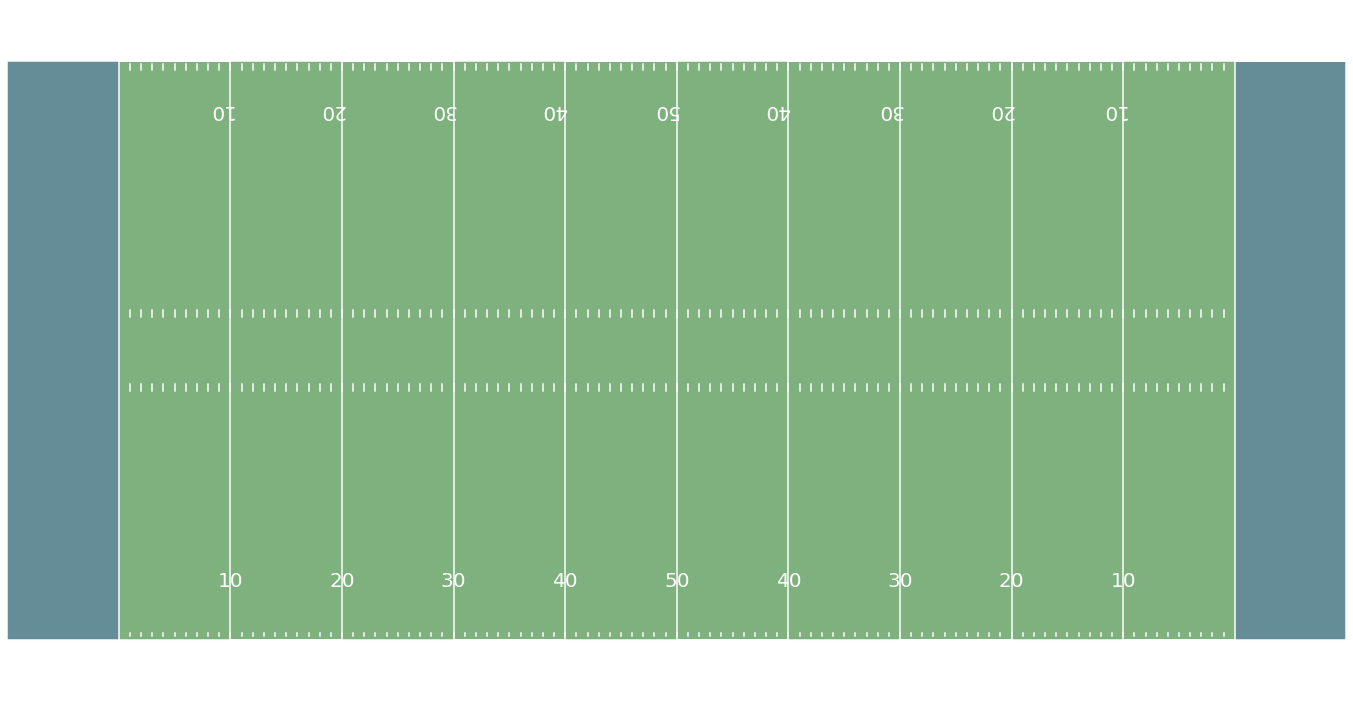

In [2]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12*2, 6.33*2)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0,  alpha=0.5)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax
create_football_field()

## Begin Data Wrangling

In [3]:
#load data
games = pd.read_csv('Data/games.csv')
pff = pd.read_csv('Data/pffScoutingData.csv')
players = pd.read_csv('Data/players.csv')
plays = pd.read_csv('Data/plays.csv')
week1 = pd.read_csv('Data/week1.csv')

In [4]:
# join dataframes
games = games.drop(['gameTimeEastern', 'gameDate', 'week', 'season'], axis = 1)
players = players[['nflId', 'displayName']]
train = week1.merge(games, how = 'left', on = 'gameId')
train = train.merge(players, how = 'left', on = 'nflId')
train = train.merge(plays, how = 'left', on = ['gameId', 'playId'])
train = train.merge(pff, how = 'left', on = ['gameId', 'playId', 'nflId'])

In [5]:
train.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,homeTeamAbbr,visitorTeamAbbr,displayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,TB,DAL,Tom Brady,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None,TB,DAL,Tom Brady,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None,TB,DAL,Tom Brady,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None,TB,DAL,Tom Brady,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None,TB,DAL,Tom Brady,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#create dummy variables to tell if player is moving left and if the player is a right wr, as well as change direction to radians
train['toLeft'] = train.playDirection == 'left'
train['isWR'] = train.pff_positionLinedUp == 'RWR'
train['dir_rad'] = np.mod(90 - train.dir, 360) * math.pi/180

In [7]:
#is the player on home team or away?
train['homeOrAway'] = 'home'
train.loc[train.team == train.visitorTeamAbbr, 'homeOrAway'] = 'away'

In [8]:
#orient the offense to always go left to right
train['teamOnOffense'] = "home"
train.loc[train.possessionTeam != train.homeTeamAbbr, 'teamOnOffense'] = "away"
train['isOnOffense'] = train.homeOrAway == train.teamOnOffense # Is player on offense?
train['yardLine_std'] = 100 - train.yardlineNumber
train.loc[train.yardlineSide.fillna('') == train.possessionTeam,  
          'yardLine_std'
         ] = train.loc[train.yardlineSide.fillna('') == train.possessionTeam,  
          'yardlineNumber']
train['x_std'] = train.x
train.loc[train.toLeft, 'x_std'] = 120 - train.loc[train.toLeft, 'x'] 
train['y_std'] = train.y
train.loc[train.toLeft, 'y_std'] = 160/3 - train.loc[train.toLeft, 'y'] 
#train['Orientation_std'] = -90 + train.Orientation
#train.loc[train.ToLeft, 'Orientation_std'] = np.mod(180 + train.loc[train.ToLeft, 'Orientation_std'], 360)
train['dir_std'] = train.dir_rad
train.loc[train.toLeft, 'dir_std'] = np.mod(np.pi + train.loc[train.toLeft, 'dir_rad'], 2*np.pi)

## Direction Visualization

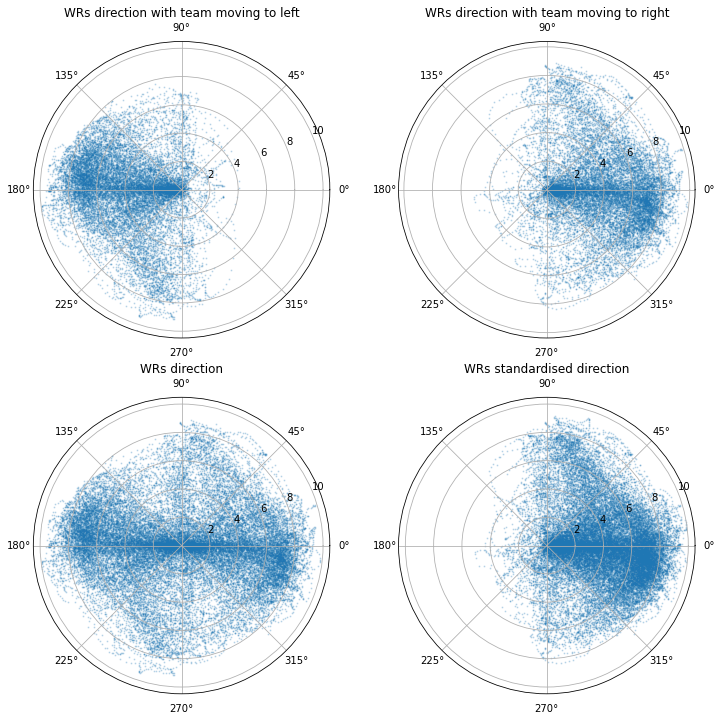

In [9]:
plt.figure(figsize=(12, 12))
ax = plt.subplot(221, projection='polar')
df = train[train.toLeft & train.isWR]
ax.set_title('WRs direction with team moving to left')
ax.scatter(df.dir_rad, df.s, s=1, alpha=0.2)

ax = plt.subplot(222, projection='polar')
df = train[~train.toLeft & train.isWR]
ax.set_title('WRs direction with team moving to right')
ax.scatter(df.dir_rad, df.s, s=1, alpha=0.2)

ax = plt.subplot(223, projection='polar')
df = train[train.isOnOffense & train.isWR]
ax.set_title('WRs direction')
ax.scatter(df.dir_rad, df.s, s=1, alpha=0.2)

ax = plt.subplot(224, projection='polar')
df = train[train.isOnOffense & train.isWR]
ax.set_title('WRs standardised direction')
ax.scatter(df.dir_std, df.s, s=1, alpha=0.2)

As desired, all players are moving from left to right.

## Orientation Visualization

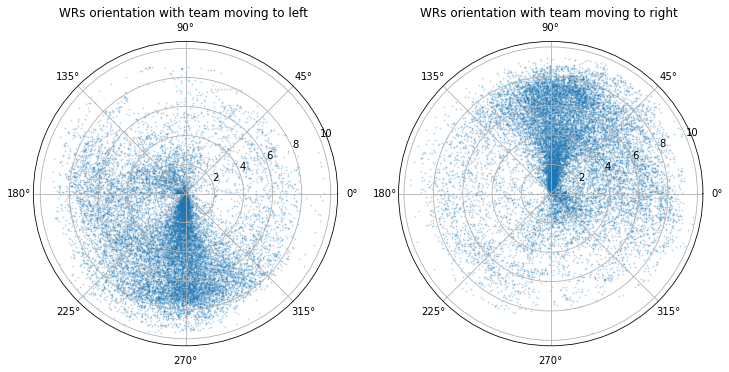

In [10]:
train['o_rad'] = np.mod(train.o, 360) * math.pi/180.0

plt.figure(figsize=(12, 18))
ax = plt.subplot(223, projection='polar')
df = train[train.toLeft & train.isWR]
ax.set_title('WRs orientation with team moving to left ')
ax.scatter(df.o_rad, df.s, s=1, alpha=0.2)

ax = plt.subplot(224, projection='polar')
df = train[~train.toLeft & train.isWR]
ax.set_title('WRs orientation with team moving to right ')
ax.scatter(df.o_rad, df.s, s=1, alpha=0.2)

 Looks like the players are oriented towards the sidelines, let's fix their orientation.

In [11]:
train['o_rad'] = np.mod(train['o'] - 90, 360) * math.pi/180.0

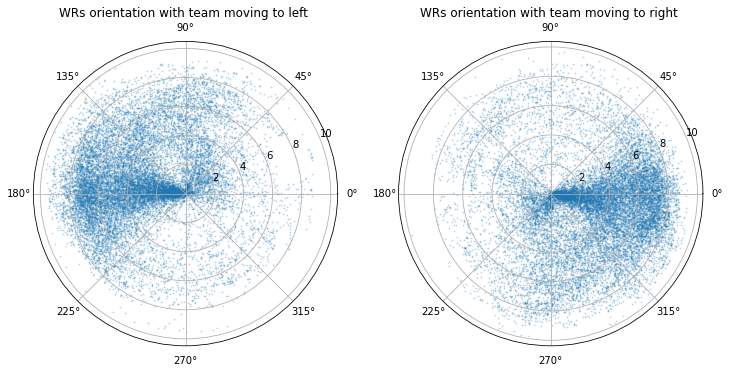

In [12]:
plt.figure(figsize=(12, 18))
ax = plt.subplot(223, projection='polar')
df = train[train.toLeft & train.isWR]
ax.set_title('WRs orientation with team moving to left ')
ax.scatter(df.o_rad, df.s, s=1, alpha=0.2)

ax = plt.subplot(224, projection='polar')
df = train[~train.toLeft & train.isWR]
ax.set_title('WRs orientation with team moving to right ')
ax.scatter(df.o_rad, df.s, s=1, alpha=0.2)

Now let's standardize the orientation... 

In [14]:
train['o_rad'] = np.mod(train.o, 360) * math.pi/180.0
train['o_rad'] = np.mod(train.o - 90, 360) * math.pi/180.0
train['o_std'] = train.o_rad
train.loc[train.toLeft, 'o_std'] = np.mod(np.pi + train.loc[train.toLeft, 'o_rad'], 2*np.pi)

and check it out.

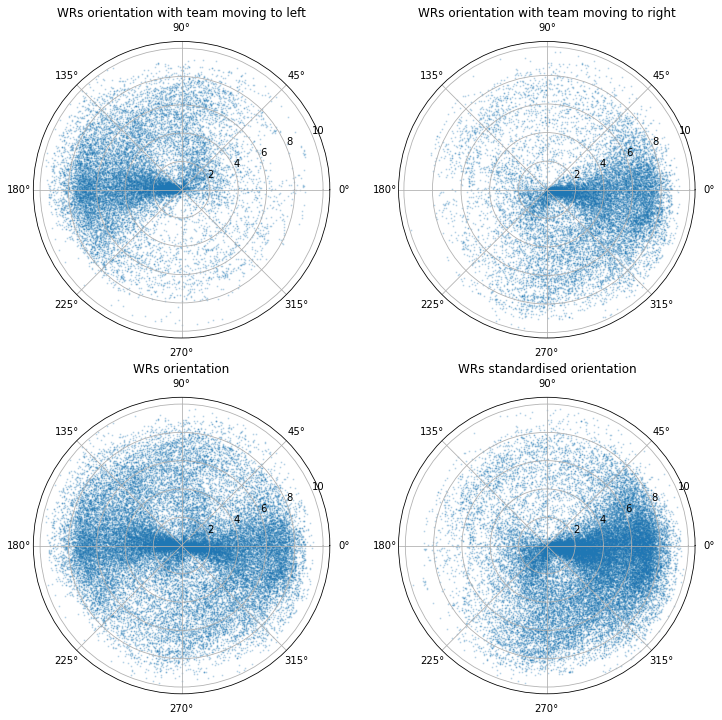

In [18]:
plt.figure(figsize=(12, 12))
ax = plt.subplot(221, projection='polar')
df = train[train.toLeft & train.isWR]
ax.set_title('WRs orientation with team moving to left')
ax.scatter(df.o_rad, df.s, s=1, alpha=0.2)

ax = plt.subplot(222, projection='polar')
df = train[~train.toLeft & train.isWR]
ax.set_title('WRs orientation with team moving to right')
ax.scatter(df.o_rad, df.s, s=1, alpha=0.2)

ax = plt.subplot(223, projection='polar')
df = train[train.isOnOffense & train.isWR]
ax.set_title('WRs orientation')
ax.scatter(df.o_rad, df.s, s=1, alpha=0.2)

ax = plt.subplot(224, projection='polar')
df = train[train.isOnOffense & train.isWR]
ax.set_title('WRs standardised orientation')
ax.scatter(df.o_std, df.s, s=1, alpha=0.2)

Looks standardized to me :)

## Define Function to Prep Data

In [13]:
def data_prep():

SyntaxError: unexpected EOF while parsing (<ipython-input-13-89dcce483681>, line 1)